# New York City's Flood Zone Exploratory Data Analysis
Author: Mark Bauer

Table of Contents
=================

   [1. Introduction](#blank)
   
       
   [2. The files](#blank)
   - [2.1 Inspecting the data](#blank)
   - [2.2 Dropping unnecessary columns](#blank)
   - [2.3 Inspecting our geometry column](#blank)   
       
       
   [3. Inspecting flood zones and static base flood elevation values](#blank)
   - [3.1 Replacing -9999 values with null](#blank)
   - [3.2 Dropping unnecessary flood zone values](#blank)
   - [3.3 Exporting cleaned dataset](#blank)
   
  
   [4. Inspect the geometry of the data](#blank)
   - [4.1 Mapping the flood zone](#blank)
   - [4.2 Analyzing the flood zone's area](#blank)

# 1. Introduction

I've wanted to do this project for some time now, and I'm finally happy to share this open source project. This notebook demonstrates how to analyze FEMA's Preliminary Flood Insurance Rate Map (i.e. PFIRM), sometimes known as '*flood zone*.' The flood zone is for New York City (all five boroughs). Let's see what cool things we can discover about this dataset!

# Resources Before Getting Started

NYC's Preliminary Flood Insurance Rate Map (PFIRM) data can be downloaded here:  
http://www.region2coastal.com/view-flood-maps-data/view-preliminary-flood-map-data/

![website](imgs/fema-pfirm-website.png)

*Figure 1. Screenshot of website of the pfirm data*

![image](imgs/data-for-nyc.png)

*Figure 2. Screenshot of data section for New York City*

About the data: 
>The Digital Flood Insurance Rate Map (DFIRM) Database depicts flood risk information and supporting data used to develop the risk data. The primary risk classifications used are the 1-percent-annual-chance flood event, the 0.2-percent-annual-chance flood event, and areas of minimal flood risk. The DFIRM Database is derived from Flood Insurance Studies (FISs), previously published Flood Insurance Rate Maps (FIRMs), flood hazard analyses performed in support of the FISs and FIRMs, and new mapping data, where available. The FISs and FIRMs are published by the Federal Emergency Management Agency (FEMA). The file is georeferenced to earth's surface using the State Plane projection and coordinate system. The specifications for the horizontal control of DFIRM data files are consistent with those required for mapping at a scale of 1:12,000.

General identification information about this dataset
>Originator: Federal Emergency Management Agency  
Publication_Date: 20150130  
Title: DIGITAL FLOOD INSURANCE RATE MAP DATABASE,  CITY OF NEW YORK, NEW YORK  
Geospatial_Data_Presentation_Form: FEMA-DFIRM-Preliminary  
Publication_Information:
>Publication_Place: Washington, DC  
Publisher: Federal Emergency Management Agency  
Online_Linkage: https://msc.fema.gov    

To read the full Preliminary Flood Insurance Study mentioned above:  
https://msc.fema.gov/portal/downloadProduct?productID=360497V000B    

Unfortunately, there is no data dictionary provided in the download. To learn more about each column, the [metadata](https://github.com/mebauer/nyc-floodzone-analysis/blob/master/pfirm-nyc/360497_PRELIM_metadata.txt) points to **Guidelines and Specifications for Flood Hazard Mapping Partners: Appendix L: Guidance for Preparing Draft Digital Data and DFIRM Database.** You can find this resource at the Homeland Security Digital Library located here: https://www.hsdl.org/?abstract&did=13285. I've also uploaded this resource for you with the title [data-dictionary.pdf](https://github.com/mebauer/nyc-floodzone-analysis/blob/master/data-dictionary.pdf).

![data-dictionary-screenshot.png](imgs/data-dictionary-screenshot.png)

*Figure 3. Screenshot of data dictionary webpage*

# Libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import urllib.request
from zipfile import ZipFile
import fiona

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
print('printing packages and versions:\n')

%reload_ext watermark
%watermark -v -p numpy,pandas,seaborn,matplotlib.pyplot,geopandas

printing packages and versions:

CPython 3.7.1
IPython 7.20.0

numpy 1.19.2
pandas 1.2.1
seaborn 0.11.1
matplotlib.pyplot 3.3.2
geopandas 0.8.1


![copy_data_address](imgs/copy-data-address.png)

*Figure 4. Screenshot of data path*

***Uncomment the code below to download the files from the web.***

In [3]:
# # url path from the web
# url = 'https://msc.fema.gov/portal/downloadProduct?productID=360497_PRELIMDB'
# print('data url path:', url)

# # assigning file name as 'pfirm_nyc.zip'
# urllib.request.urlretrieve(url, 'pfirm-nyc.zip')

# # listing files in our directory
print('listing the new downloaded file in our directory:')
%ls

listing the new downloaded file in our directory:
CODE_OF_CONDUCT.md              environment.yml
CONTRIBUTING.md                 floodzone-pfirm-analysis.ipynb
LICENSE                         imgs/
README.md                       pfirm-nyc/
data-dictionary.pdf             pfirm-nyc-map.png
data-output/                    pfirm-nyc.zip


***Uncomment the code below to unzip and extract the files from the zip file.***

In [4]:
# path = 'pfirm-nyc.zip'
# print('name of zip file:', path)

# # opening zip using 'with' keyword in read mode
# with zipfile.ZipFile(path, 'r') as file:
#     # extracing all items in our zipfile
#     # naming our file 'pfirm-nyc'
#     file.extractall('pfirm-nyc')

print('listing items after unzipping the file:\n')
%ls pfirm-nyc/    

listing items after unzipping the file:

360497_PRELIM_metadata.txt  s_fld_haz_ar.shx
360497_PRELIM_metadata.xml  s_fld_haz_ln.dbf
L_PAN_REVIS.dbf             s_fld_haz_ln.shp
L_POL_FHBM.dbf              s_fld_haz_ln.shx
S_BASE_INDEX.prj            s_gen_struct.dbf
S_BFE.prj                   s_gen_struct.shp
S_CBRS.prj                  s_gen_struct.shx
S_CST_TSCT_LN.dbf           s_label_ld.dbf
S_CST_TSCT_LN.prj           s_label_ld.prj
S_CST_TSCT_LN.shp           s_label_ld.sbn
S_CST_TSCT_LN.shx           s_label_ld.sbx
S_FIRM_PAN.prj              s_label_ld.shp
S_FLD_HAZ_AR.prj            s_label_ld.shx
S_FLD_HAZ_LN.prj            s_label_pt.dbf
S_GEN_STRUCT.prj            s_label_pt.prj
S_LiMWA.dbf                 s_label_pt.sbn
S_LiMWA.prj                 s_label_pt.sbx
S_LiMWA.shp                 s_label_pt.shp
S_LiMWA.shx                 s_label_pt.shx
S_PERM_BMK.prj              s_perm_bmk.dbf
S_POL_AR.prj                s_perm_bmk.shp
S_POL_LN.prj                s_perm_bmk.shx

# 2. The files

For this analysis, we are interested in the special flood hazard area shapefile - `s_fld_haz_ar.shp`. This contains information about the flood zone. A shapefile is geospatial vector data for geographic information system software and stores geometric location and associated attribute information.

Data description from metadata:

>Entity_Type_Label: s_fld_haz_ar  
Entity_Type_Definition: Location and attributes for flood insurance risk zones on the DFIRM.


For more information about our columns and their descriptions, please find the [metadata files](https://github.com/mebauer/nyc-floodzone-analysis/blob/master/pfirm-nyc/360497_PRELIM_metadata.txt) located in the pfirm_nyc folder.

## 2.1 Inspecting the data

In [5]:
# reading in shape file
path = 'pfirm-nyc/s_fld_haz_ar.shp'
pfirm_df = gpd.read_file(path)

# previewing first five rorws of data
pfirm_df.head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,VEL_UNIT,AR_REVERT,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,82,X,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."


In [6]:
# previewing last five rorws of data
pfirm_df.tail()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,VEL_UNIT,AR_REVERT,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
3980,4061,AE,FLOODWAY,T,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY3,"POLYGON ((948012.835 151530.411, 948018.441 15..."
3981,4062,AE,None,T,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY3,"POLYGON ((1019981.024 235220.224, 1019960.066 ..."
3982,4063,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1019888.296 235113.767, 1019910.519 ..."
3983,4064,AE,None,T,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY3,"POLYGON ((1020681.583 235274.734, 1020618.617 ..."
3984,4065,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1020681.583 235274.734, 1020700.681 ..."


In [7]:
print('dataframe shape:\n')

rows = pfirm_df.shape[0]
columns = pfirm_df.shape[1]

print('number of rows: {:,}.\nnumber of columns: {}.'.format(rows, columns))

dataframe shape:

number of rows: 3,985.
number of columns: 15.


In this dataset, each row is a flood zone geometry. The type of flood zone can be inspected under the `FLD_ZONE` column. Additionally, there are 15 columns that contain information about each flood zone row.

In [8]:
print('type of python object:\n\n{}'.format(type(pfirm_df)))

type of python object:

<class 'geopandas.geodataframe.GeoDataFrame'>


We read the shapefile into Python as a GeoDataFrame. This type is similar to a pandas dataframe, but includes additional spatial information - mainly, our `geometry` column. The geometry column contains polygons that represent the physical space of each flood zone.

quickly inspecting our map.


<AxesSubplot:>

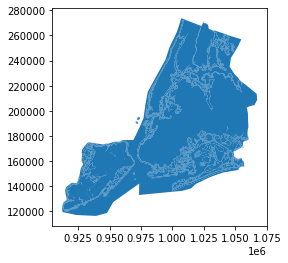

In [9]:
print('quickly inspecting our map.')
pfirm_df.plot()

In [10]:
# summary of the data
pfirm_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FLD_AR_ID   3985 non-null   object  
 1   FLD_ZONE    3985 non-null   object  
 2   FLOODWAY    47 non-null     object  
 3   SFHA_TF     3985 non-null   object  
 4   STATIC_BFE  3985 non-null   float64 
 5   V_DATUM     1153 non-null   object  
 6   DEPTH       3985 non-null   float64 
 7   LEN_UNIT    1165 non-null   object  
 8   VELOCITY    3985 non-null   float64 
 9   VEL_UNIT    0 non-null      object  
 10  AR_REVERT   0 non-null      object  
 11  BFE_REVERT  3985 non-null   float64 
 12  DEP_REVERT  3985 non-null   float64 
 13  SOURCE_CIT  3985 non-null   object  
 14  geometry    3985 non-null   geometry
dtypes: float64(5), geometry(1), object(9)
memory usage: 467.1+ KB


We notice that there are two columns that are completely null - `VEL_UNIT` and `AR_REVERT`. We may be able to safely drop them in the future.

In [11]:
print('count of data types:')
pfirm_df.dtypes.value_counts()

count of data types:


object      9
float64     5
geometry    1
dtype: int64

In [12]:
print('summary statistics for numeric columns:')
pfirm_df.describe()

summary statistics for numeric columns:


,STATIC_BFE,DEPTH,VELOCITY,BFE_REVERT,DEP_REVERT
count,3985.000000,3985.000000,3985.0,3985.0,3985.0
mean,-7101.950314,-9968.883061,-9999.0,-9999.0,-9999.0
std,4540.905248,548.067414,0.0,0.0,0.0
min,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0
25%,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0
50%,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0
75%,11.000000,-9999.000000,-9999.0,-9999.0,-9999.0
max,34.000000,3.000000,-9999.0,-9999.0,-9999.0


There seems to be weird values of -9999 in the numeric columns. Possibly placeholders for null values. We will inspect these values later.

In [13]:
print('summary statistics for string/object columns:')
pfirm_df.describe(include='object')

summary statistics for string/object columns:


,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,V_DATUM,LEN_UNIT,VEL_UNIT,AR_REVERT,SOURCE_CIT
count,3985,3985,47,3985,1153,1165,0,0,3985
unique,3985,7,1,2,1,1,0,0,3
top,1135,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,FLOODWAY,F,NAVD88,FEET,NaN,NaN,STUDY4
freq,1,1726,47,2263,1153,1165,NaN,NaN,2937


In [14]:
print('summary statistics for all column types:')
pfirm_df.drop(columns='geometry').describe(include='all').T

summary statistics for all column types:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FLD_AR_ID,3985,3985,1135,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLD_ZONE,3985,7,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,1726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLOODWAY,47,1,FLOODWAY,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SFHA_TF,3985,2,F,2263,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATIC_BFE,3985.0,NaN,NaN,NaN,-7101.950314,4540.905248,-9999.0,-9999.0,-9999.0,11.0,34.0
V_DATUM,1153,1,NAVD88,1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEPTH,3985.0,NaN,NaN,NaN,-9968.883061,548.067414,-9999.0,-9999.0,-9999.0,-9999.0,3.0
LEN_UNIT,1165,1,FEET,1165,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VELOCITY,3985.0,NaN,NaN,NaN,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
VEL_UNIT,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 3)

print('null statistics of each column:')
pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)

null statistics of each column:


,count_null,normalized
VEL_UNIT,3985,1.000
AR_REVERT,3985,1.000
FLOODWAY,3938,0.988
V_DATUM,2832,0.711
LEN_UNIT,2820,0.708
FLD_AR_ID,0,0.000
FLD_ZONE,0,0.000
SFHA_TF,0,0.000
STATIC_BFE,0,0.000
DEPTH,0,0.000


In [16]:
print('total number of nulls in data: {:,}.'.format(pfirm_df.isnull().sum().sum()))

total number of nulls in data: 17,560.


Now that we have a better understanding of our data, let's come back to those 100% null value columns and see if we can safely drop them

## 2.2 Dropping unnecessary columns

Definitions from our data dictionary:

VEL_UNIT
>Velocity Unit Lookup Identification. A code that provides a link to a valid unit of velocity from the D_Vel_Units table. This unit indicates the measurement system for the velocity of the flood hazard area. The value is shown in the legend where alluvial fans are present. This field is only populated if the VELOCITY field is populated.

AR_REVERT
>If the area is Zone AR, this field would hold the zone that the area would revert to if the AR zone were removed. This field is only populated if the corresponding area is Zone AR. Acceptable values for this field are listed in the D_Zone table.

In [17]:
# previewing columns that are 100% null
pfirm_df[['VEL_UNIT', 'AR_REVERT']].head()

,VEL_UNIT,AR_REVERT
0,None,None
1,None,None
2,None,None
3,None,None
4,None,None


In [18]:
# inspecting items within these columns
for col in ['VEL_UNIT', 'AR_REVERT']:
    print(pfirm_df[col].value_counts())

Series([], Name: VEL_UNIT, dtype: int64)
Series([], Name: AR_REVERT, dtype: int64)


There are no values besides `None` in these columns, and we can safely drop these.

In [19]:
print('number of columns: {}'.format(pfirm_df.shape[1]))

# dropping 100% null columns
pfirm_df = pfirm_df.drop(columns=['VEL_UNIT', 'AR_REVERT'])
print('new number of columns: {}\n'.format(pfirm_df.shape[1]))

pfirm_df.head()

number of columns: 15
new number of columns: 13



,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,82,X,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."


In [20]:
# let's preview our null counts after droppping those columns
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 2)

print('null statistics:')
pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)

null statistics:


,count_null,normalized
FLOODWAY,3938,0.99
V_DATUM,2832,0.71
LEN_UNIT,2820,0.71
FLD_AR_ID,0,0.00
FLD_ZONE,0,0.00
SFHA_TF,0,0.00
STATIC_BFE,0,0.00
DEPTH,0,0.00
VELOCITY,0,0.00
BFE_REVERT,0,0.00


In [21]:
print('reviewing items in FLOODWAY column that is almost 100% null')
pfirm_df['FLOODWAY'].value_counts(dropna=False)

reviewing items in FLOODWAY column that is almost 100% null


NaN         3938
FLOODWAY      47
Name: FLOODWAY, dtype: int64

Although `FLOODWAY` is 99% null, it still has non-null values. Let's keep the column.

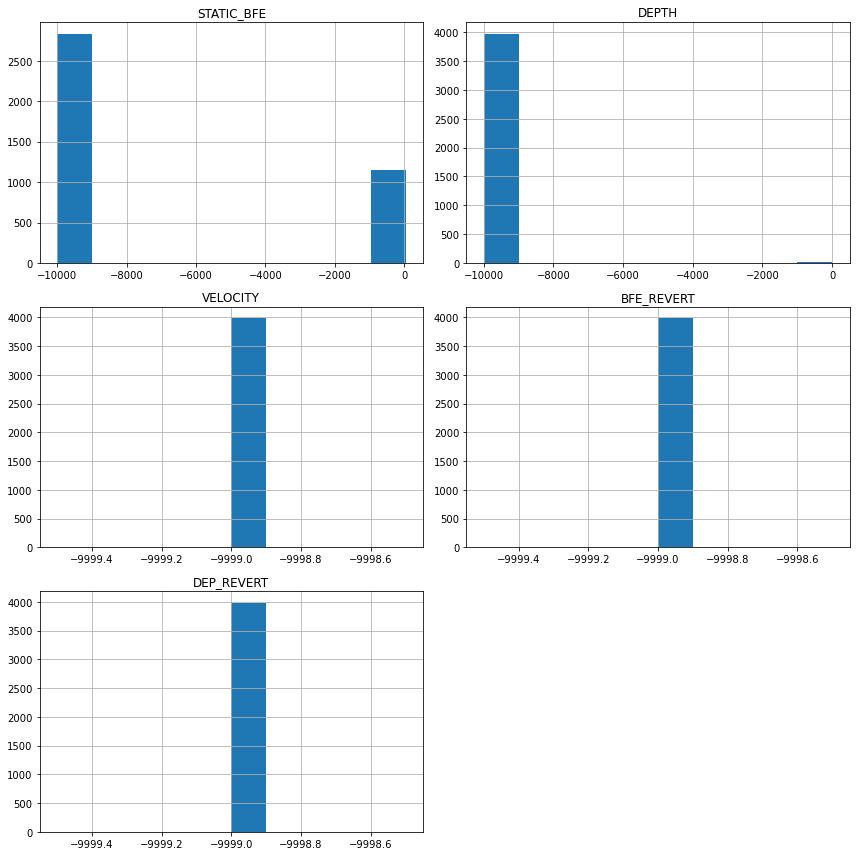

In [22]:
# plotting histograms of numeric columns
pfirm_df.hist(figsize=(12,12))
plt.tight_layout()

There seems to be some outliers in these columns. Let's inspect them.

Previewing items within each column. hopefully we'll find columns that are not 100% null but are still not useful for this analysis.

In [23]:
for col in pfirm_df.columns:
    # geometry type does not have a .value_counts() method
    if col == 'geometry':
        continue
    print(col, 'value counts:')    
    print(pfirm_df[col].value_counts(dropna=False, normalize=True).head())
    print()

FLD_AR_ID value counts:
1135    0.000251
1635    0.000251
3756    0.000251
452     0.000251
3111    0.000251
Name: FLD_AR_ID, dtype: float64

FLD_ZONE value counts:
0.2 PCT ANNUAL CHANCE FLOOD HAZARD    0.433124
AE                                    0.318444
X                                     0.132748
VE                                    0.105395
A                                     0.005270
Name: FLD_ZONE, dtype: float64

FLOODWAY value counts:
NaN         0.988206
FLOODWAY    0.011794
Name: FLOODWAY, dtype: float64

SFHA_TF value counts:
F    0.56788
T    0.43212
Name: SFHA_TF, dtype: float64

STATIC_BFE value counts:
-9999.0    0.710665
 13.0      0.055458
 14.0      0.038896
 11.0      0.036888
 12.0      0.036136
Name: STATIC_BFE, dtype: float64

V_DATUM value counts:
NaN       0.710665
NAVD88    0.289335
Name: V_DATUM, dtype: float64

DEPTH value counts:
-9999.0    0.996989
 3.0       0.001757
 1.0       0.000753
 2.0       0.000502
Name: DEPTH, dtype: float64

LEN_UNIT valu

Reviewing possible columns to drop. After reviewing items within each column, there are a few columns that have only one value as well as values that look off (e.g. -9999.0.). Let's continue to inspect these columns.

In [24]:
pfirm_df.iloc[:, -5:-1].head()

,VELOCITY,BFE_REVERT,DEP_REVERT,SOURCE_CIT
0,-9999.0,-9999.0,-9999.0,STUDY4
1,-9999.0,-9999.0,-9999.0,STUDY4
2,-9999.0,-9999.0,-9999.0,STUDY4
3,-9999.0,-9999.0,-9999.0,STUDY4
4,-9999.0,-9999.0,-9999.0,STUDY4


In [25]:
# summary statistics of possible columns to drop
pfirm_df.iloc[:, -5:-1].describe()

,VELOCITY,BFE_REVERT,DEP_REVERT
count,3985.0,3985.0,3985.0
mean,-9999.0,-9999.0,-9999.0
std,0.0,0.0,0.0
min,-9999.0,-9999.0,-9999.0
25%,-9999.0,-9999.0,-9999.0
50%,-9999.0,-9999.0,-9999.0
75%,-9999.0,-9999.0,-9999.0
max,-9999.0,-9999.0,-9999.0


These columns don't appear to be useful in this analysis, so I'll drop them.

In [26]:
print('number of initial columns: {}'.format(pfirm_df.shape[1]))

col_drop = pfirm_df.iloc[:, -5:-1].columns
print('columns to drop:', col_drop.to_list())

pfirm_df = pfirm_df.drop(columns=col_drop)
print('number of new columns: {}'.format(pfirm_df.shape[1]))

pfirm_df.head()

number of initial columns: 13
columns to drop: ['VELOCITY', 'BFE_REVERT', 'DEP_REVERT', 'SOURCE_CIT']
number of new columns: 9


,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,82,X,None,F,-9999.0,None,-9999.0,None,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."


Let's continue inspecting our data.

In [27]:
# inspecting our data
pfirm_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FLD_AR_ID   3985 non-null   object  
 1   FLD_ZONE    3985 non-null   object  
 2   FLOODWAY    47 non-null     object  
 3   SFHA_TF     3985 non-null   object  
 4   STATIC_BFE  3985 non-null   float64 
 5   V_DATUM     1153 non-null   object  
 6   DEPTH       3985 non-null   float64 
 7   LEN_UNIT    1165 non-null   object  
 8   geometry    3985 non-null   geometry
dtypes: float64(2), geometry(1), object(6)
memory usage: 280.3+ KB


In [28]:
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 2)

print('null statistics:')
pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)

null statistics:


,count_null,normalized
FLOODWAY,3938,0.99
V_DATUM,2832,0.71
LEN_UNIT,2820,0.71
FLD_AR_ID,0,0.00
FLD_ZONE,0,0.00
SFHA_TF,0,0.00
STATIC_BFE,0,0.00
DEPTH,0,0.00
geometry,0,0.00


We've inspecting most of our columns, and even dropped some that didn't have any values stored in them. We did see wierd values such as -9999, but for now, let's turn our attention to our geometry column.

## 2.3 Inspecting our geometry column

Lastly, let's inspect our geometry column, which is a type provided by the shapefile (.shp) format.

In [29]:
print('reviewing geometry column:')
pfirm_df[['geometry']].head()

reviewing geometry column:


,geometry
0,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
2,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."


In [30]:
pfirm_df[['geometry']].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  3985 non-null   geometry
dtypes: geometry(1)
memory usage: 31.3 KB


In [31]:
print("reviewing the geometry's coordinate referance system (CRS).")
pfirm_df.crs

reviewing the geometry's coordinate referance system (CRS).


<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

From the `.crs` attribute above, our geometry's CRS is *NAD83 / New York Long Island (ftUS)* - code 2263.
Our units are in feet.

In [32]:
# looking at the values in the V_DATUM column
pfirm_df['V_DATUM'].value_counts()

NAVD88    1153
Name: V_DATUM, dtype: int64

We could potentially drop this column and just record the vertical datum on the page, but this does provide useful information. Let's keep it.

In [33]:
v_datum = pfirm_df['V_DATUM'].value_counts().index[0]

print('the vertical datum for this geometry is: {}.'.format(v_datum))

the vertical datum for this geometry is: NAVD88.


There's a lot of useful information stored in our geometry column, but for now, let's continue and inspect our flood zone values.

# 3. Inspecting flood zones and static base flood elevation values

Definitions from our [data dictionary](https://github.com/mebauer/nyc-floodzone-analysis/blob/master/data-dictionary.pdf):

FLD_ZONE
>Flood Zone Lookup Identification. This is a code that provides a link to a valid entry from the D_Zone table. This is the flood zone label/abbreviation for the area.

STATIC_BFE
>Static Base Flood Elevation. For areas of constant Base Flood Elevation (BFE), the BFE value is shown beneath the zone label rather than on a BFE line. In this situation the same BFE applies to the entire polygon. This is normally occurs in lakes or coastal zones. This field is only populated where a static BFE is shown on the FIRM.

DEPTH
>Depth Value for Zone AO Areas. This is shown beneath the zone label on the FIRM. This field is only populated if a depth is shown on the FIRM.

SFHA_TF
>Special Flood Hazard Area. If the area is within SFHA this field would be True. This field will be true for any area that is coded for any A or V zone flood areas. It should be false for any X or D zone flood areas. Enter “T” for true or “F” for false.

Brief definition of FEMA's flood zones:

>Flood hazard areas identified on the Flood Insurance Rate Map are identified as a Special Flood Hazard Area (SFHA). SFHA are defined as the area that will be inundated by the flood event having a 1-percent chance of being equaled or exceeded in any given year. The 1-percent annual chance flood is also referred to as the base flood or 100-year flood. SFHAs are labeled as Zone A, Zone AO, Zone AH, Zones A1-A30, Zone AE, Zone A99, Zone AR, Zone AR/AE, Zone AR/AO, Zone AR/A1-A30, Zone AR/A, Zone V, Zone VE, and Zones V1-V30. Moderate flood hazard areas, labeled Zone B or Zone X (shaded) are also shown on the FIRM, and are the areas between the limits of the base flood and the 0.2-percent-annual-chance (or 500-year) flood. The areas of minimal flood hazard, which are the areas outside the SFHA and higher than the elevation of the 0.2-percent-annual-chance flood, are labeled Zone C or Zone X (unshaded).  

Source: https://www.fema.gov/glossary/flood-zones

In [34]:
print('reviewing items in the FLD_ZONE column:')

pfirm_df['FLD_ZONE'].value_counts()

reviewing items in the FLD_ZONE column:


0.2 PCT ANNUAL CHANCE FLOOD HAZARD    1726
AE                                    1269
X                                      529
VE                                     420
A                                       21
AO                                      12
OPEN WATER                               8
Name: FLD_ZONE, dtype: int64

In [35]:
zone_vals = pfirm_df['FLD_ZONE'].unique()

print('the unique values in our flood zone column are:\n\n{}'.format(zone_vals))

the unique values in our flood zone column are:

['AE' 'X' '0.2 PCT ANNUAL CHANCE FLOOD HAZARD' 'VE' 'OPEN WATER' 'AO' 'A']


From a quick glance, we can probably drop the `OPEN WATER` value, as this is probably only the outline of a water boundary. Additionally, zone 'X' doesn't tell us any useul information about flood zones.

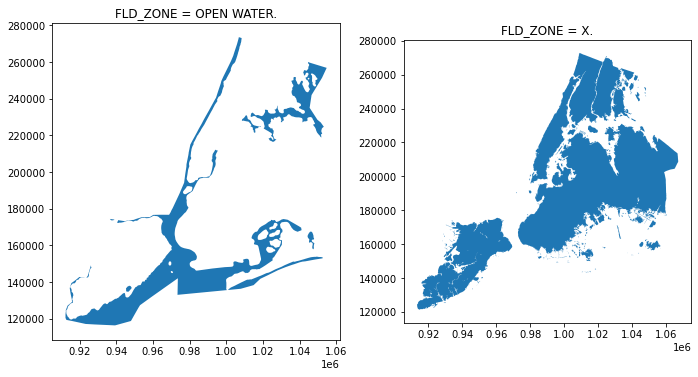

In [36]:
zone_checks = ['OPEN WATER', 'X']

fig, axs = plt.subplots(1, 2, figsize=(10,10))

for zone, ax in zip(zone_checks, axs.flat):
    
    pfirm_df[pfirm_df['FLD_ZONE'].isin([zone])].plot(ax=ax)
    ax.set_title('FLD_ZONE = {}.'.format(zone))
    
fig.tight_layout()

Let's look at some summary statistics.

In [37]:
print('reviewing summary statistics for base flood elevations by flood zone:')

pfirm_df.groupby(by=['FLD_ZONE'])['STATIC_BFE'].describe()

reviewing summary statistics for base flood elevations by flood zone:


,count,mean,std,min,25%,50%,75%,max
FLD_ZONE,,,,,,,,
0.2 PCT ANNUAL CHANCE FLOOD HAZARD,1726.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
A,21.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
AE,1269.0,-4216.189125,4946.985064,-9999.0,-9999.0,10.0,13.0,23.0
AO,12.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
OPEN WATER,8.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
VE,420.0,16.133333,3.126045,11.0,14.0,16.0,17.0,34.0
X,529.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [38]:
# zones with base flood elevations
bfe_df = pfirm_df.groupby(by=['FLD_ZONE'])['STATIC_BFE'].describe()
bfe_df.loc[bfe_df['max'] > 0]

,count,mean,std,min,25%,50%,75%,max
FLD_ZONE,,,,,,,,
AE,1269.0,-4216.189125,4946.985064,-9999.0,-9999.0,10.0,13.0,23.0
VE,420.0,16.133333,3.126045,11.0,14.0,16.0,17.0,34.0


In [39]:
zones = bfe_df.loc[bfe_df['max'] > 0].index.to_list()

print('zones {} are the only zones that have static base flood elevations.'.format(zones))

zones ['AE', 'VE'] are the only zones that have static base flood elevations.


The null placeholder of -9999 will be problematic in the future. We will want to replace these with nulls.

In [40]:
print('reviewing summary statistics for depth elevations by flood zone:')

pfirm_df.groupby(by=['FLD_ZONE'])['DEPTH'].describe()

reviewing summary statistics for depth elevations by flood zone:


,count,mean,std,min,25%,50%,75%,max
FLD_ZONE,,,,,,,,
0.2 PCT ANNUAL CHANCE FLOOD HAZARD,1726.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
A,21.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
AE,1269.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
AO,12.0,2.333333,0.887625,1.0,1.75,3.0,3.0,3.0
OPEN WATER,8.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
VE,420.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0
X,529.0,-9999.000000,0.000000,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0


In [41]:
# zones with base flood elevations
depths_df = pfirm_df.groupby(by=['FLD_ZONE'])['DEPTH'].describe()
depths_df.loc[depths_df['max'] > 0]

,count,mean,std,min,25%,50%,75%,max
FLD_ZONE,,,,,,,,
AO,12.0,2.333333,0.887625,1.0,1.75,3.0,3.0,3.0


In [42]:
depths = depths_df.loc[depths_df['max'] > 0].index.to_list()

print('zone {} is the only zone that has a depth elevation.'.format(depths))

zone ['AO'] is the only zone that has a depth elevation.


In [43]:
sfha_df = pfirm_df.groupby(by=['SFHA_TF', 'FLD_ZONE'])['STATIC_BFE'].describe()

sfha_df.sort_values(by='SFHA_TF', ascending=False)

count         mean          std  \
SFHA_TF FLD_ZONE                                                               
T       A                                     21.0 -9999.000000     0.000000   
        AE                                  1269.0 -4216.189125  4946.985064   
        AO                                    12.0 -9999.000000     0.000000   
        VE                                   420.0    16.133333     3.126045   
F       0.2 PCT ANNUAL CHANCE FLOOD HAZARD  1726.0 -9999.000000     0.000000   
        OPEN WATER                             8.0 -9999.000000     0.000000   
        X                                    529.0 -9999.000000     0.000000   

                                               min     25%     50%     75%  \
SFHA_TF FLD_ZONE                                                             
T       A                                  -9999.0 -9999.0 -9999.0 -9999.0   
        AE                                 -9999.0 -9999.0    10.0    13.0   
        AO                                 -9999.0 -9999.0 -9999.0 -9999.0   
        VE                                    11.0    14.0    16.0    17.0   
F       0.2 PCT ANNUAL CHANCE FLOOD HAZARD -9999.0 -9999.0 -9999.0 -9999.0   
        OPEN WATER                         -9999.0 -9999.0 -9999.0 -9999.0   
        X                                  -9999.0 -9999.0 -9999.0 -9999.0   

                                               max  
SFHA_TF FLD_ZONE                                    
T       A                                  -9999.0  
        AE                                    23.0  
        AO                                 -9999.0  
        VE                                    34.0  
F       0.2 PCT ANNUAL CHANCE FLOOD HAZARD -9999.0  
        OPEN WATER                         -9999.0  
        X                                  -9999.0

Although zones A & AO don't have base flood elevations, they are inside the special flood hazard area (SFHA). Thus, we can not drop them. 


`T` stands for **True** and `F` stands for **False**.

## 3.1 Replacing -9999 values with null

It seems to be that this dataset represents null values for certain numeric columns as -9999 (refer to screenshot below). Let's see what the values are if we exclude these values.

![null_information](imgs/null-information.png)

*Figure 5. Screenshot of null description found in data dictionary*

In [44]:
pfirm_df.loc[pfirm_df['STATIC_BFE'] > -9999][['STATIC_BFE']].describe()

,STATIC_BFE
count,1153.000000
mean,13.786644
std,2.996455
min,8.000000
25%,12.000000
50%,13.000000
75%,15.000000
max,34.000000


Those values look much better and are probably the real statistics of our static base flood elevation column. For this analysis, we can safely replace the -9999.0 values with nulls. Let's first track our replacement process.

In [45]:
null_length = len(pfirm_df.loc[pfirm_df['STATIC_BFE'] <= -9999])

print('there are {:,} values with null placeholders of -9999 for STATIC_BFE that \
need to be replaced with nulls.'.format(null_length))

there are 2,832 values with null placeholders of -9999 for STATIC_BFE that need to be replaced with nulls.


In [46]:
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 3)

print('null statistics:')
print('total nulls in dataframe: {:,}.'.format(s1.sum()))

before_replace_df = pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)
before_replace_df.head(len(before_replace_df))

null statistics:
total nulls in dataframe: 9,590.


,count_null,normalized
FLOODWAY,3938,0.988
V_DATUM,2832,0.711
LEN_UNIT,2820,0.708
FLD_AR_ID,0,0.000
FLD_ZONE,0,0.000
SFHA_TF,0,0.000
STATIC_BFE,0,0.000
DEPTH,0,0.000
geometry,0,0.000


In [47]:
print('replacing incorrectly inserted values (e.g. -9999) with nans.')

for col in ['STATIC_BFE', 'DEPTH']:
    
    # if our column value is less than -1, replace with nan, else keep column value
    pfirm_df[col] = np.where(pfirm_df[col] < -1, np.nan, pfirm_df[col])
    
pfirm_df.describe()    

replacing incorrectly inserted values (e.g. -9999) with nans.


,STATIC_BFE,DEPTH
count,1153.000000,12.000000
mean,13.786644,2.333333
std,2.996455,0.887625
min,8.000000,1.000000
25%,12.000000,1.750000
50%,13.000000,3.000000
75%,15.000000,3.000000
max,34.000000,3.000000


In [48]:
s1 = pfirm_df.isnull().sum().sort_values(ascending=False)
s2 = round(pfirm_df.isnull().sum().sort_values(ascending=False) / len(pfirm_df), 3)

print('null statistics:')
print('total nulls in dataframe: {:,}.'.format(s1.sum()))

after_replace_df = pd.concat([s1.rename('count_null'), s2.rename('normalized')], axis=1)
after_replace_df.head(len(after_replace_df))

null statistics:
total nulls in dataframe: 16,395.


,count_null,normalized
DEPTH,3973,0.997
FLOODWAY,3938,0.988
STATIC_BFE,2832,0.711
V_DATUM,2832,0.711
LEN_UNIT,2820,0.708
FLD_AR_ID,0,0.000
FLD_ZONE,0,0.000
SFHA_TF,0,0.000
geometry,0,0.000


In [49]:
pd.concat([before_replace_df, 
           after_replace_df.rename(columns={'count_null':'count_after', 
                                            'normalized':'normalized_after'})], axis=1)

,count_null,normalized,count_after,normalized_after
FLOODWAY,3938,0.988,3938,0.988
V_DATUM,2832,0.711,2832,0.711
LEN_UNIT,2820,0.708,2820,0.708
FLD_AR_ID,0,0.000,0,0.000
FLD_ZONE,0,0.000,0,0.000
SFHA_TF,0,0.000,0,0.000
STATIC_BFE,0,0.000,2832,0.711
DEPTH,0,0.000,3973,0.997
geometry,0,0.000,0,0.000


You can see that both columns static_bfe and depth have a significant amount of null values after replacing -9999 with null.

## 3.2 Reviewing summary statistics by flood zone after filling  in nulls

In [50]:
print('reviewing summary statistics for static base flood elevations by flood zone:')

pfirm_df.groupby(by=['FLD_ZONE'])['STATIC_BFE'].describe()

reviewing summary statistics for static base flood elevations by flood zone:


,count,mean,std,min,25%,50%,75%,max
FLD_ZONE,,,,,,,,
0.2 PCT ANNUAL CHANCE FLOOD HAZARD,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE,733.0,12.442019,1.888557,8.0,11.0,12.0,14.0,23.0
AO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OPEN WATER,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VE,420.0,16.133333,3.126045,11.0,14.0,16.0,17.0,34.0
X,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
sfha_df = pfirm_df.groupby(by=['SFHA_TF', 'FLD_ZONE'])['STATIC_BFE'].describe()

sfha_df.sort_values(by='SFHA_TF', ascending=False)

count       mean       std   min  \
SFHA_TF FLD_ZONE                                                               
T       A                                     0.0        NaN       NaN   NaN   
        AE                                  733.0  12.442019  1.888557   8.0   
        AO                                    0.0        NaN       NaN   NaN   
        VE                                  420.0  16.133333  3.126045  11.0   
F       0.2 PCT ANNUAL CHANCE FLOOD HAZARD    0.0        NaN       NaN   NaN   
        OPEN WATER                            0.0        NaN       NaN   NaN   
        X                                     0.0        NaN       NaN   NaN   

                                             25%   50%   75%   max  
SFHA_TF FLD_ZONE                                                    
T       A                                    NaN   NaN   NaN   NaN  
        AE                                  11.0  12.0  14.0  23.0  
        AO                                   NaN   NaN   NaN   NaN  
        VE                                  14.0  16.0  17.0  34.0  
F       0.2 PCT ANNUAL CHANCE FLOOD HAZARD   NaN   NaN   NaN   NaN  
        OPEN WATER                           NaN   NaN   NaN   NaN  
        X                                    NaN   NaN   NaN   NaN

Performing summary statistics of static base flood elevations grouped by Special Flood Hazard Area (True/False) and Flood Zone. Zones AE and VE are the only ones with elevation values, and the remaining zones have null values.

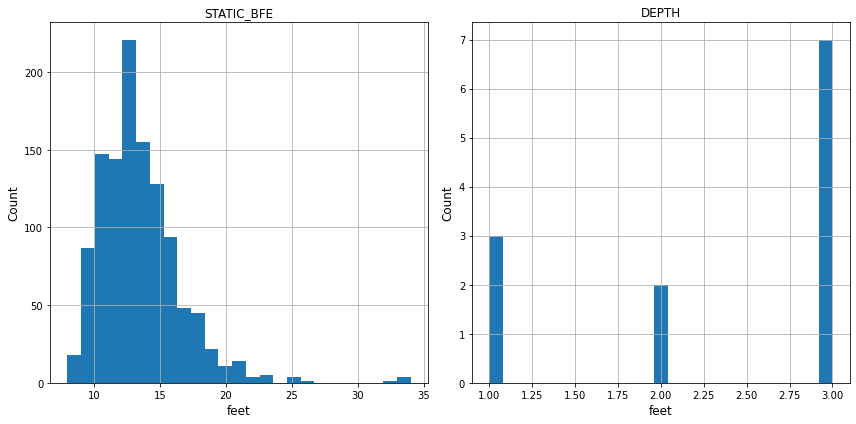

In [52]:
hist = pfirm_df.hist(figsize=(12,6), bins=25)

for ax in hist.flatten():
    ax.set_xlabel("feet", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    
plt.tight_layout()    

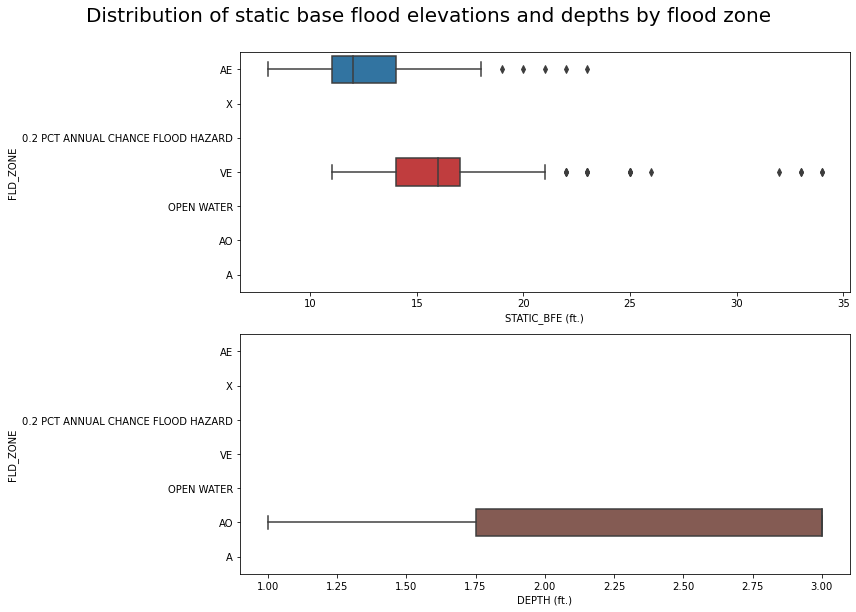

In [53]:
fig, axs = plt.subplots(2, 1, figsize=(12,9))

for ax, col in zip(axs.flat, ['STATIC_BFE', 'DEPTH']):
    
    sns.boxplot(x=col, 
                y="FLD_ZONE", 
                data=pfirm_df, 
                ax=ax)
    
    ax.set_xlabel(col + ' (ft.)')
    plt.suptitle('Distribution of static base flood elevations and depths by flood zone\n\n', 
                 y=.94, 
                 fontsize=20)
    
fig.tight_layout()    

Flood zones VE and AE are the only zones that have a static base flood elevation (BFE) value. Flood zone AO is the only zone with a depth elevation, although these depths are very small.

## 3.2 Dropping unnecessary flood zone values

There are two flood zones in particular, X and OPEN WATER, that may be good candidates to drop. We don't want to drop any flood zones in the special flood hazard area (AE, VE, A, and AO), and we also don't want to drop the 0.2 % annual chance flood zone (although outside of the special flood hazard area, this information is still quite useful). Let's see if we can safely drop the previously mentioned values safely.

In [54]:
# number of records in each flood zone
pfirm_df['FLD_ZONE'].value_counts()

0.2 PCT ANNUAL CHANCE FLOOD HAZARD    1726
AE                                    1269
X                                      529
VE                                     420
A                                       21
AO                                      12
OPEN WATER                               8
Name: FLD_ZONE, dtype: int64

In [55]:
# preview the dataframe where flood zones are open water and x
pfirm_df.loc[pfirm_df['FLD_ZONE'].isin(['OPEN WATER', 'X'])].head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry
1,82,X,None,F,NaN,None,NaN,None,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
6,87,X,None,F,NaN,None,NaN,None,"POLYGON ((1034013.168 257011.473, 1034007.732 ..."
11,92,X,None,F,NaN,None,NaN,None,"POLYGON ((1043995.696 257160.314, 1043996.904 ..."
15,96,X,None,F,NaN,None,NaN,None,"POLYGON ((1034329.553 253484.038, 1034317.702 ..."
19,100,X,None,F,NaN,None,NaN,None,"POLYGON ((1029438.728 251094.008, 1029442.937 ..."


In [56]:
# summary statistics where flood zones are open water and x
pfirm_df.loc[pfirm_df['FLD_ZONE'].isin(['OPEN WATER', 'X'])].iloc[:, :-1].describe(include='all')

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT
count,537,537,0,537,0.0,0,0.0,0
unique,537,2,0,1,NaN,0,NaN,0
top,1135,X,NaN,F,NaN,NaN,NaN,NaN
freq,1,529,NaN,537,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# preview count of records grouped by flood zones are open water and x
d1 = pfirm_df.loc[pfirm_df['FLD_ZONE'].isin(['OPEN WATER', 'X'])]

d1.groupby(by=['FLD_ZONE', 'SFHA_TF']).count()

,,FLD_AR_ID,FLOODWAY,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry
FLD_ZONE,SFHA_TF,,,,,,,
OPEN WATER,F,8,0,0,0,0,0,8
X,F,529,0,0,0,0,0,529


In [58]:
print('number of records in total data frame: {:,}'.format(pfirm_df.shape[0]))

length = pfirm_df.loc[pfirm_df['FLD_ZONE'].isin(['OPEN WATER', 'X'])].shape[0]
print('number of records to drop where flood zone is open water and x: {:,}'.format(length))

pfirm_df = pfirm_df.loc[~pfirm_df['FLD_ZONE'].isin(['OPEN WATER', 'X'])]
print('number of records in dataframe after dropping open water and x zones: {:,}'.format(pfirm_df.shape[0]))

number of records in total data frame: 3,985
number of records to drop where flood zone is open water and x: 537
number of records in dataframe after dropping open water and x zones: 3,448


In [59]:
# our dropped flood zones are no longer included in dataframe
pfirm_df.groupby(by=['SFHA_TF', 'FLD_ZONE']).count()

FLD_AR_ID  FLOODWAY  STATIC_BFE  \
SFHA_TF FLD_ZONE                                                              
F       0.2 PCT ANNUAL CHANCE FLOOD HAZARD       1726         0           0   
T       A                                          21         0           0   
        AE                                       1269        47         733   
        AO                                         12         0           0   
        VE                                        420         0         420   

                                            V_DATUM  DEPTH  LEN_UNIT  geometry  
SFHA_TF FLD_ZONE                                                                
F       0.2 PCT ANNUAL CHANCE FLOOD HAZARD        0      0         0      1726  
T       A                                         0      0         0        21  
        AE                                      733      0       733      1269  
        AO                                        0     12        12        12  
        VE                                      420      0       420       420

In [60]:
# number of records in each flood zone
pfirm_df['FLD_ZONE'].value_counts()

0.2 PCT ANNUAL CHANCE FLOOD HAZARD    1726
AE                                    1269
VE                                     420
A                                       21
AO                                      12
Name: FLD_ZONE, dtype: int64

<AxesSubplot:>

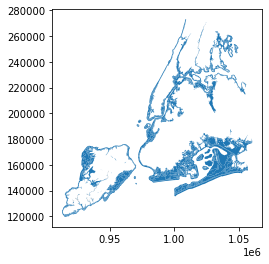

In [61]:
# a quick preview of our map after dropping open water and x flood zones
pfirm_df.plot()

In [62]:
# summary statistics of data
pfirm_df.iloc[:, :-1].describe(include='all')

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT
count,3448,3448,47,3448,1153.000000,1153,12.000000,1165
unique,3448,5,1,2,NaN,1,NaN,1
top,3880,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,FLOODWAY,F,NaN,NAVD88,NaN,FEET
freq,1,1726,47,1726,NaN,1153,NaN,1165
mean,NaN,NaN,NaN,NaN,13.786644,NaN,2.333333,NaN
std,NaN,NaN,NaN,NaN,2.996455,NaN,0.887625,NaN
min,NaN,NaN,NaN,NaN,8.000000,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,12.000000,NaN,1.750000,NaN
50%,NaN,NaN,NaN,NaN,13.000000,NaN,3.000000,NaN
75%,NaN,NaN,NaN,NaN,15.000000,NaN,3.000000,NaN


In [63]:
# summary of data
pfirm_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3448 entries, 0 to 3984
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FLD_AR_ID   3448 non-null   object  
 1   FLD_ZONE    3448 non-null   object  
 2   FLOODWAY    47 non-null     object  
 3   SFHA_TF     3448 non-null   object  
 4   STATIC_BFE  1153 non-null   float64 
 5   V_DATUM     1153 non-null   object  
 6   DEPTH       12 non-null     float64 
 7   LEN_UNIT    1165 non-null   object  
 8   geometry    3448 non-null   geometry
dtypes: float64(2), geometry(1), object(6)
memory usage: 269.4+ KB


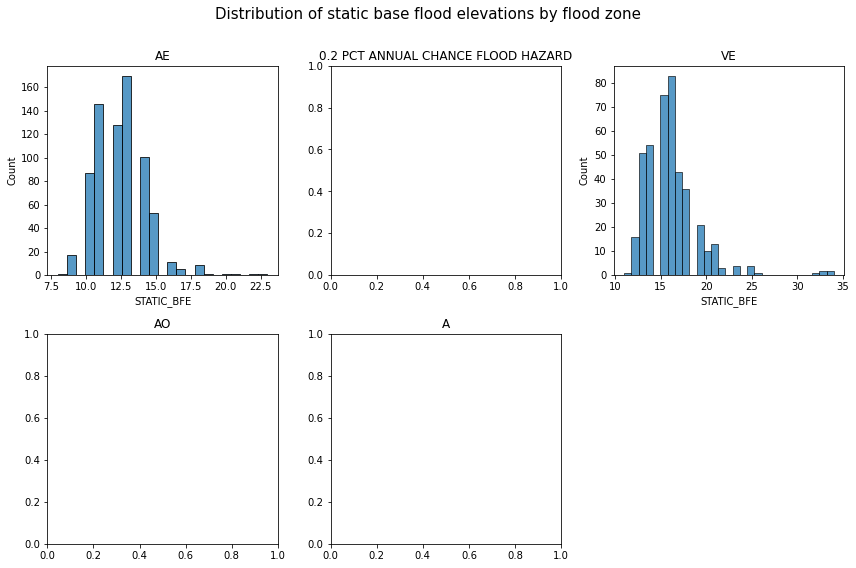

In [64]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
zones = list(pfirm_df['FLD_ZONE'].unique())

for zone, ax in zip(zones, axs.flat):

    sns.histplot(data=pfirm_df.loc[pfirm_df['FLD_ZONE'].isin([zone])], 
                 x='STATIC_BFE', 
                 ax=ax)

    ax.set_title('{}'.format(zone))
    
axs[1, 2].axis('off')

plt.suptitle('Distribution of static base flood elevations by flood zone\n', fontsize=15)
fig.tight_layout()

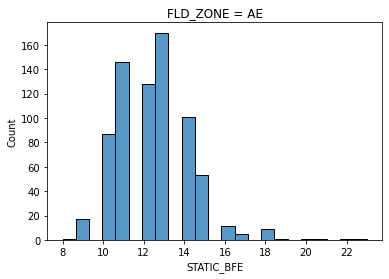

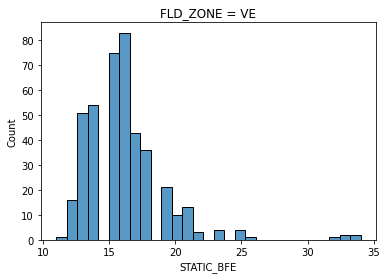

In [65]:
# plotting static base flood elevations distribution by flood zone per plot
zones = pfirm_df['FLD_ZONE'].unique()

for zone in zones:
    plot_df = pfirm_df.loc[pfirm_df['FLD_ZONE'] == zone]
    if plot_df['STATIC_BFE'].value_counts().sum() < 1:
        continue
        
    plt.figure()    
    sns.histplot(plot_df, x='STATIC_BFE')
    plt.title('FLD_ZONE = {}'.format(zone))

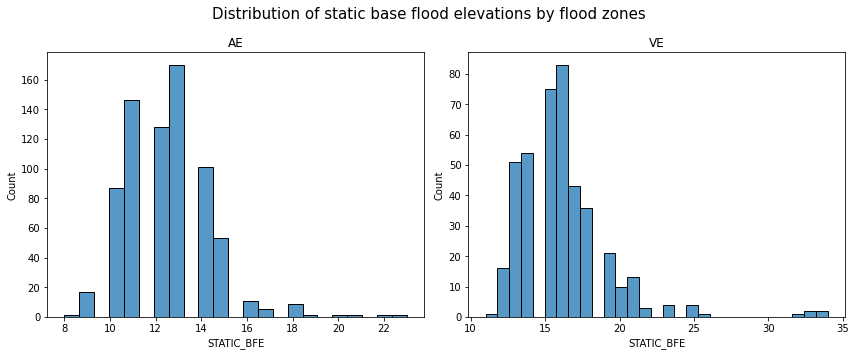

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
zones = ['AE', 'VE']

for zone, ax in zip(zones, axs.flat):

    sns.histplot(data=pfirm_df.loc[pfirm_df['FLD_ZONE'].isin([zone])], 
                 x='STATIC_BFE', 
                 ax=ax)

    ax.set_title('{}'.format(zone))
    
plt.suptitle('Distribution of static base flood elevations by flood zones', fontsize=15)
fig.tight_layout()

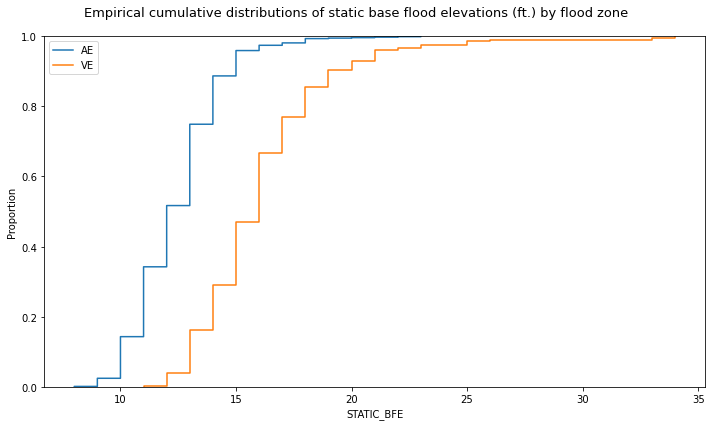

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))

for zone in ['AE', 'VE']:

    sns.ecdfplot(data=pfirm_df.loc[pfirm_df['FLD_ZONE'].isin([zone])], 
                 x="STATIC_BFE", 
                 ax=ax, 
                 label=zone)
    
    ax.legend(loc=2)
    
plt.suptitle('Empirical cumulative distributions of static base flood elevations (ft.) by flood zone', fontsize=13)    
fig.tight_layout()    

In [68]:
# previewing count of records by within special flood hazard area
pfirm_df['SFHA_TF'].value_counts()

F    1726
T    1722
Name: SFHA_TF, dtype: int64

In [69]:
# summary statistics of static base flood elevations by special flood hazard area
pfirm_df.groupby(by=['SFHA_TF'])['STATIC_BFE'].describe()

,count,mean,std,min,25%,50%,75%,max
SFHA_TF,,,,,,,,
F,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,1153.0,13.786644,2.996455,8.0,12.0,13.0,15.0,34.0


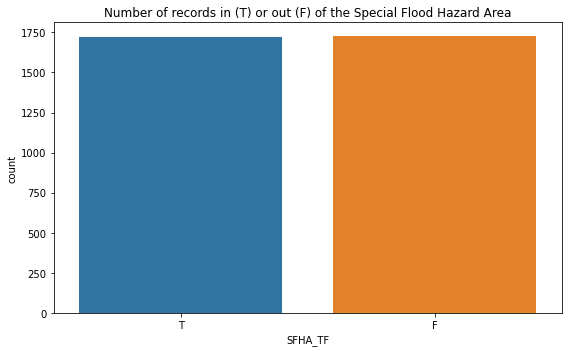

In [70]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.countplot(x="SFHA_TF", 
              data=pfirm_df, 
              ax=ax)

plt.title('Number of records in (T) or out (F) of the Special Flood Hazard Area', fontsize=12)
plt.tight_layout()

The count of records within or outside of our SFHA is similar - 1722 inside and 1726 outside.

## 3.3 Exporting cleaned dataset

In [71]:
print(type(pfirm_df))
print('rows, columns:')
pfirm_df.shape

<class 'geopandas.geodataframe.GeoDataFrame'>
rows, columns:


(3448, 9)

In [72]:
# exporting as a shapefile
pfirm_df.to_file("data-output/pfirm-nyc.shp")

# exporting as a geojson
pfirm_df.to_file("data-output/pfirm-nyc.geojson", driver='GeoJSON')

# exporting as a csv
df = pd.DataFrame(pfirm_df)
df.to_csv("data-output/pfirm-nyc.csv", index=False)

In [73]:
# sanity checks
print('rows, columns:')
print(gpd.read_file('data-output/pfirm-nyc.shp').shape)
print(pd.read_csv('data-output/pfirm-nyc.csv').shape)

rows, columns:
(3448, 9)
(3448, 9)


In [74]:
# sanity checks
gpd.read_file('data-output/pfirm-nyc.shp').head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry
0,81,AE,None,T,13.0,NAVD88,NaN,FEET,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
2,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
3,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."
4,86,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033316.808 262437.816, 1033316.108 ..."


# 4. Inspect the geometry of the data

## 4.1 Mapping the flood zone

![borough_boundaries](imgs/nyc-borough-screenshot.png)

*Figure 6. Screenshot of borough boundaries page on nyc open data*

Website link: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

In [75]:
# importing borough boundaries for better aesthetics
path = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'

borough_gdf = gpd.read_file(path)
borough_gdf.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1.0,Manhattan,6.366208e+08,359993.127161,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
1,2.0,Bronx,1.187194e+09,463868.935588,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,3.0,Brooklyn,1.934174e+09,728195.194837,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
3,5.0,Staten Island,1.623631e+09,325924.002252,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
4,4.0,Queens,3.040206e+09,900269.281914,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


Text(0.5, 1.0, 'nyc boroughs')

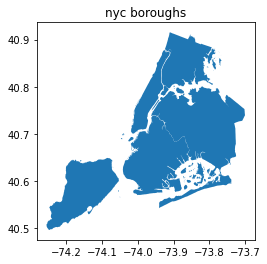

In [76]:
# quick plot of boroughs
borough_gdf.plot()
plt.title('nyc boroughs')

epsg:2263


Text(0.5, 1.0, 'nyc boroughs')

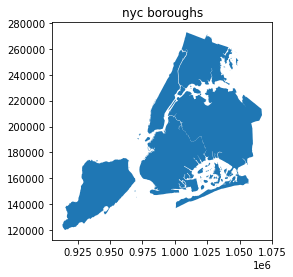

In [77]:
# converting to the state plane crs of our floodzone dataframe
borough_gdf = borough_gdf.to_crs(epsg=2263)
print(borough_gdf.crs)

borough_gdf.plot()
plt.title('nyc boroughs')

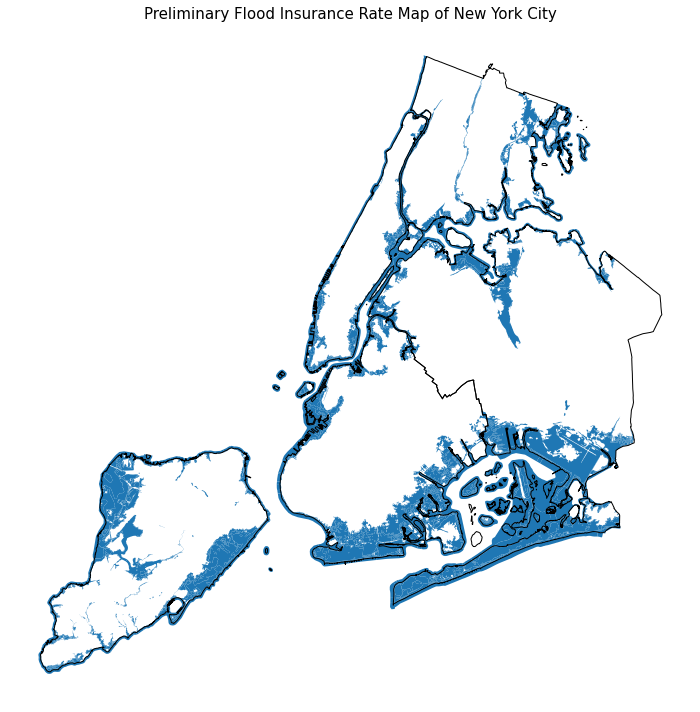

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))

pfirm_df.plot(ax=ax)
borough_gdf.plot(ax=ax, 
                 facecolor='none', 
                 edgecolor='black', 
                 zorder=1)

plt.axis('off')
plt.title('Preliminary Flood Insurance Rate Map of New York City', fontsize=15)
plt.tight_layout()

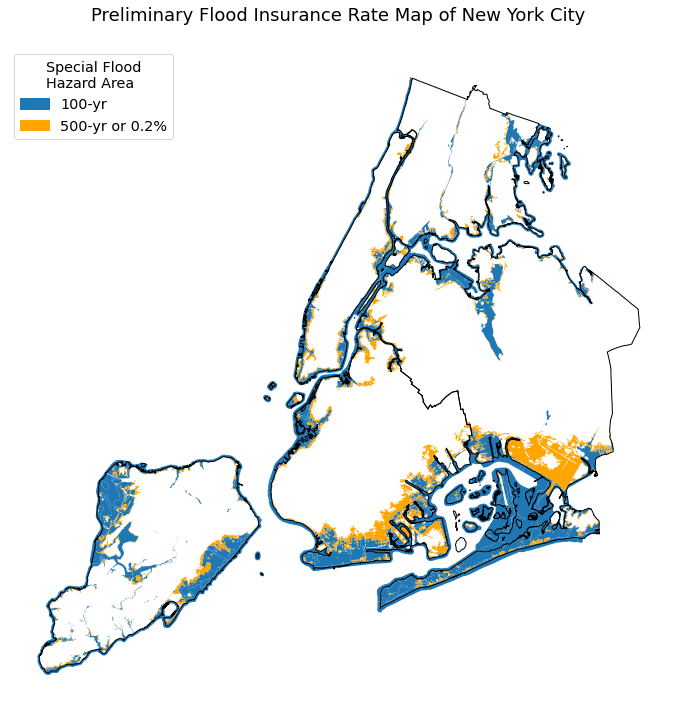

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))

sfha_true = pfirm_df.loc[~pfirm_df['FLD_ZONE'].isin(['0.2 PCT ANNUAL CHANCE FLOOD HAZARD'])]
sfha_true.plot(color='C0', 
               ax=ax, 
               zorder=0)

sfha_false = pfirm_df.loc[pfirm_df['FLD_ZONE'].isin(['0.2 PCT ANNUAL CHANCE FLOOD HAZARD'])]
sfha_false.plot(color='orange', 
                ax=ax)

borough_gdf.plot(ax=ax, 
                 facecolor='none', 
                 edgecolor='black', 
                 zorder=2)

blue_patch = mpatches.Patch(color='C0', label='100-yr')
orange_patch = mpatches.Patch(color='orange', label='500-yr or 0.2%')

plt.legend(title='Special Flood\nHazard Area', 
           handles=[blue_patch, orange_patch], 
           fontsize='x-large', 
           title_fontsize='x-large',
           loc=2)

plt.axis('off')
plt.title('Preliminary Flood Insurance Rate Map of New York City\n', fontsize=18)
plt.tight_layout()
plt.savefig('pfirm-nyc-map.png', dpi=300)

In [80]:
# preview active crs
pfirm_df.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [81]:
# adding a column for our geometry converted to WGS84
pfirm_df['wgs84'] = pfirm_df.to_crs(epsg=4326)['geometry']

pfirm_df.head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,geometry,wgs84
0,81,AE,None,T,13.0,NAVD88,NaN,FEET,"POLYGON ((1032001.691 263867.839, 1032006.047 ...","POLYGON ((-73.82729 40.89080, -73.82728 40.890..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033309.701 263544.181, 1033322.210 ...","POLYGON ((-73.82256 40.88991, -73.82252 40.889..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033414.148 262658.868, 1033414.934 ...","POLYGON ((-73.82219 40.88747, -73.82219 40.887..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1034089.115 262466.034, 1034089.402 ...","POLYGON ((-73.81975 40.88694, -73.81975 40.886..."
5,86,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,NaN,None,NaN,None,"POLYGON ((1033316.808 262437.816, 1033316.108 ...","POLYGON ((-73.82255 40.88687, -73.82255 40.886..."


In [82]:
# make sure 2263 is still our active geometry
pfirm_df.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'Preliminary Flood Insurance Rate Map of New York City')

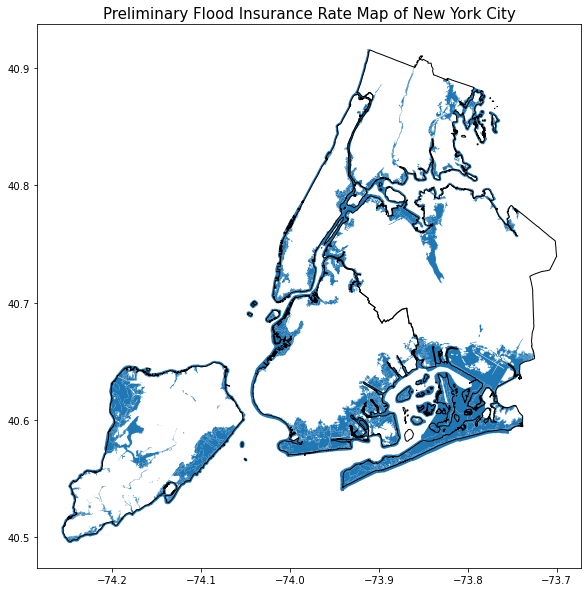

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))

# plotting our map in WGS84
pfirm_df.set_geometry('wgs84').plot(ax=ax)
borough_gdf.to_crs(epsg=4326).plot(ax=ax, 
                                   facecolor='none', 
                                   edgecolor='black', 
                                   zorder=1)

plt.title('Preliminary Flood Insurance Rate Map of New York City', fontsize=15)

## 4.2 Analyzing the flood zone's area

In [84]:
# previewing geometry's area in square ft.
pfirm_df.area.head()

0    1.414248e+07
2    1.004589e+05
3    1.935660e+05
4    6.573445e+04
5    1.275814e+05
dtype: float64

In [85]:
# converting square feet to square miles
sq_mi = pfirm_df.area / 5280**2

sq_mi.head()

0    0.507292
2    0.003603
3    0.006943
4    0.002358
5    0.004576
dtype: float64

In [86]:
# summary statistics of area in sq mi
sq_mi_df = sq_mi.to_frame().rename(columns={0:'area sq mi'})

round(sq_mi_df.describe(), 4)

,area sq mi
count,3448.0000
mean,0.0292
std,0.1554
min,0.0000
25%,0.0003
50%,0.0021
75%,0.0104
max,4.6913


Text(0, 0.5, 'count')

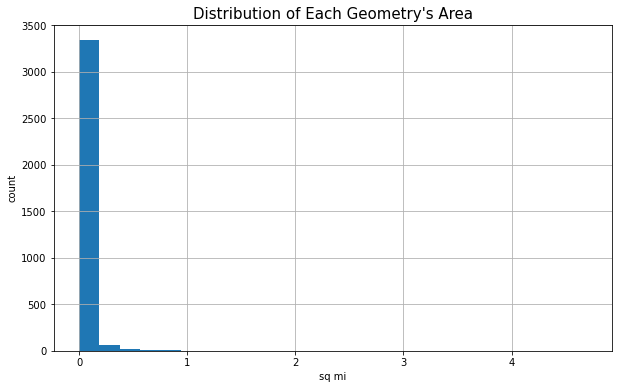

In [87]:
sq_mi_df.hist(bins=25, figsize=(10,6))
plt.title("Distribution of Each Geometry's Area", fontsize=15)
plt.xlabel('sq mi')
plt.ylabel('count')

In [88]:
print('flood zone area statistics:\n')
print('area in square feet: {:,.0f}'.format(pfirm_df.area.sum()))
print('area in square miles: {:,.0f}'.format(pfirm_df.area.sum() / 5280**2))

flood zone area statistics:

area in square feet: 2,805,616,808
area in square miles: 101


In [89]:
# creating a dataframe of only flood zones in the special flood hazard area (sfha)
# 0.2 pct chance is excluded from the sfha
sfha_df = pfirm_df[~pfirm_df['FLD_ZONE'].isin(['0.2 PCT ANNUAL CHANCE FLOOD HAZARD'])]

sfha_df['FLD_ZONE'].value_counts()

AE    1269
VE     420
A       21
AO      12
Name: FLD_ZONE, dtype: int64

In [90]:
print('area statistics only of special flood hazard area zones:\n')
print('area in square feet: {:,.0f}'.format(sfha_df.area.sum()))
print('area in square miles: {:,.0f}'.format(sfha_df.area.sum() / 5280**2))

area statistics only of special flood hazard area zones:

area in square feet: 2,251,096,443
area in square miles: 81


In [91]:
# retrieving area calculations by flood zone
zones = pfirm_df['FLD_ZONE'].unique()
empty_dict = {}

for zone in zones:
    zone_df = pfirm_df.loc[pfirm_df['FLD_ZONE'] == zone]
    zone_series = zone_df.area.sum() / 5280**2
    
    empty_dict.update({zone:zone_series})
    
empty_dict

{'AE': 47.14892801490547,
 '0.2 PCT ANNUAL CHANCE FLOOD HAZARD': 19.890681149361665,
 'VE': 33.36574122021985,
 'AO': 0.035765507846687306,
 'A': 0.1965393640507153}

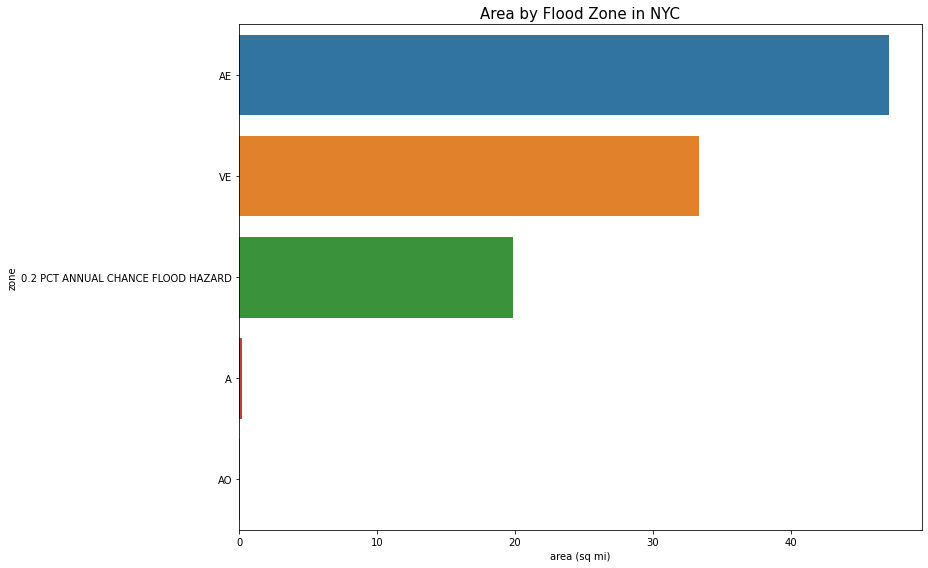

In [92]:
s1 = pd.Series(empty_dict).rename('area (sq mi)')
s1 = s1.reset_index().rename(columns={'index': 'zone'})
s1 = s1.sort_values(by='area (sq mi)', ascending=False)

# plot of area by flood zone
fig, ax = plt.subplots(figsize=(13, 8))

sns.barplot(data=s1, 
            x='area (sq mi)', 
            y='zone')

plt.title('Area by Flood Zone in NYC', fontsize=15)
plt.tight_layout()